## Install Dependences

In [1]:
!pip install tqdm

# Install Libraries

In [2]:
import numpy as np
import os   
import subprocess 
import random
import math

# Visual
from tqdm import tqdm
def print_red(text):
    print('\x1b[31m' + text + '\x1b[0m')
def print_yellow(text):
    print('\x1b[33m' + text + '\x1b[0m')
def print_green(text):
    print('\x1b[32m' + text + '\x1b[0m')
def print_pink(text):
    print('\x1b[35m' + text + '\x1b[0m')
def print_cyan(text):
    print('\x1b[36m' + text + '\x1b[0m')

## Ranking all annotations
Run all the possible combinations of annotations with different models and stores the winners in the variable *rounds*. There can be multiple winners.

***An annotation is a winner if it has the best value above all of the other and the best time.***

##### Example of *rounds*

|  | Ann_1 | Ann_2 | Ann_3 | Ann_4 | ... | Ann_n |
| --- | --- | --- | --- | --- | --- | --- |
| Ins_1 | 0 | 0 | 1 | 1 | ... | 0 |
| Ins_2 | 0 | 1 | 0 | 0 | ... | 1 |
| Ins_3 | 1 | 0 | 1 | 0 | ... | 0 |
| ... | ... | ... | ... | ... | ... | ... |
| Ins_m | 1 | 0 | 1 | 0 | ... | 0 |

In [3]:
def select_winners(mnts, times):
    winners = [1] * len(mnts)
    min_mnt = min(mnts)
    min_time = min(times)
    # print_green(f'min_mnt {min_mnt} min_time {min_time}.')
    for i, mnt in enumerate(mnts):
        if math.isinf(mnt):
            winners[i] = 0
        else:
            if mnt == min_mnt:
                if times[i] != min_time:
                    winners[i] = 0
            else:
                winners[i] = 0

    return winners

def annotations_winners(index, models_folder, instances_folder, timeout_mzn, timeout):
    annotations = [os.path.join(models_folder, f) for f in os.listdir(models_folder) if f.endswith('.mzn')]
    instance = [os.path.join(instances_folder, f) for f in os.listdir(instances_folder) if f.endswith('.dzn')][index]
    
    mnts = [0] * len(annotations)
    times = [0] * len(annotations)
    timeout_mzn = timeout_mzn*1000
    
    for i, annotation in tqdm(enumerate(annotations), desc='Processing Instance '+str(index), unit='items'):
        
        # Run the minizinc command for the current annotation and data file  
        cmd = f"minizinc --solver HiGHS --output-time {annotation} {instance} --output-time --solver-time-limit {timeout_mzn}"
        proc = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
        try: 
            # Get output from fzn
            stdout, stderr = proc.communicate(timeout=timeout) 
            stdout = stdout.decode()
            try:
                # Store value mnt (temp).
                start = stdout.find('mnt = ')+6
                end = stdout.find(';',start)
                mnt = int(stdout[start:end])
                # Store value time (temp).
                time = float(stdout.split(' ')[-2])
            except:
                mnt = float('inf')
                time = float('inf')
            # print_green(f'{annotation[10:-4]} with {instance[3:-4]} SOLVED: {mnt} in {time:.2f} seconds.')

        except subprocess.TimeoutExpired: 
            print_red(f'Error from minizinc: Stopping.')                
            mnt = float('inf')
            time = float('inf')
            if os.name == 'nt': # If the os is Windows
                subprocess.call(['taskkill', '/F', '/T', '/PID', str(proc.pid)]) # Force kill the process
            else:
                os.killpg(os.getpgid(proc.pid), signal.SIGTERM) # Kill the process group
                
        mnts[i] = mnt
        times[i] = time
    # print('mnts',mnts)
    # print('times',times)
    return select_winners(mnts,times)

n_instances = 100
rounds = np.zeros((n_instances, len([os.path.join('../models', f) for f in os.listdir('../models') if f.endswith('.mzn')])))

# loop through the list with a progress bar
for i in range(0, n_instances):
    instance = random.randint(0,n_instances-1)
    rounds[i]=np.array(annotations_winners(instance, '../models', '../instances',5, 10))
    print_yellow(f'Finished: {i}')
print_green(f'Done!')

# Save rounds to another file
print_cyan(f'Save rounds to another file')
path = '../models/rounds.txt'
with open(path, 'w', encoding='utf8') as file_object:
    file_object.write(str(rounds.tolist()))
print_green(f'Done!')

Processing Instance 26: 54items [04:36,  5.13s/items]


Finished: 0


Processing Instance 52: 54items [03:53,  4.32s/items]


Finished: 1


Processing Instance 99: 54items [01:45,  1.96s/items]


Finished: 2


Processing Instance 75: 54items [01:16,  1.42s/items]


Finished: 3


Processing Instance 17: 54items [01:50,  2.04s/items]


Finished: 4


Processing Instance 36: 54items [02:09,  2.40s/items]


Finished: 5


Processing Instance 50: 54items [02:01,  2.24s/items]


Finished: 6


Processing Instance 54: 54items [02:56,  3.27s/items]


Finished: 7


Processing Instance 74: 54items [04:38,  5.16s/items]


Finished: 8


Processing Instance 7: 54items [00:37,  1.43items/s]


Finished: 9


Processing Instance 43: 54items [02:44,  3.05s/items]


Finished: 10


Processing Instance 30: 54items [00:24,  2.19items/s]


Finished: 11


Processing Instance 39: 54items [01:43,  1.92s/items]


Finished: 12


Processing Instance 93: 54items [03:08,  3.49s/items]


Finished: 13


Processing Instance 18: 54items [04:38,  5.16s/items]


Finished: 14


Processing Instance 48: 54items [05:16,  5.86s/items]


Finished: 15


Processing Instance 77: 54items [02:13,  2.48s/items]


Finished: 16


Processing Instance 87: 54items [04:26,  4.93s/items]


Finished: 17


Processing Instance 9: 54items [04:38,  5.17s/items]


Finished: 18


Processing Instance 66: 54items [03:20,  3.72s/items]


Finished: 19


Processing Instance 69: 54items [04:39,  5.18s/items]


Finished: 20


Processing Instance 20: 54items [03:02,  3.39s/items]


Finished: 21


Processing Instance 58: 54items [05:10,  5.75s/items]


Finished: 22


Processing Instance 65: 54items [04:19,  4.81s/items]


Finished: 23


Processing Instance 39: 54items [01:45,  1.96s/items]


Finished: 24


Processing Instance 37: 54items [02:28,  2.75s/items]


Finished: 25


Processing Instance 22: 54items [03:00,  3.34s/items]


Finished: 26


Processing Instance 68: 54items [03:12,  3.57s/items]


Finished: 27


Processing Instance 65: 54items [04:19,  4.80s/items]


Finished: 28


Processing Instance 37: 54items [02:27,  2.73s/items]


Finished: 29


Processing Instance 23: 54items [02:44,  3.05s/items]


Finished: 30


Processing Instance 23: 54items [02:44,  3.05s/items]


Finished: 31


Processing Instance 61: 54items [01:19,  1.48s/items]


Finished: 32


Processing Instance 89: 54items [00:56,  1.04s/items]


Finished: 33


Processing Instance 57: 54items [02:12,  2.45s/items]


Finished: 34


Processing Instance 57: 54items [02:12,  2.45s/items]


Finished: 35


Processing Instance 38: 54items [05:02,  5.61s/items]


Finished: 36


Processing Instance 86: 54items [04:39,  5.18s/items]


Finished: 37


Processing Instance 45: 54items [02:47,  3.10s/items]


Finished: 38


Processing Instance 60: 54items [00:55,  1.02s/items]


Finished: 39


Processing Instance 81: 54items [00:13,  3.94items/s]


Finished: 40


Processing Instance 61: 54items [01:21,  1.50s/items]


Finished: 41


Processing Instance 44: 54items [00:43,  1.25items/s]


Finished: 42


Processing Instance 21: 54items [04:13,  4.69s/items]


Finished: 43


Processing Instance 8: 54items [00:20,  2.60items/s]


Finished: 44


Processing Instance 18: 54items [04:38,  5.16s/items]


Finished: 45


Processing Instance 8: 54items [00:20,  2.60items/s]


Finished: 46


Processing Instance 99: 54items [01:46,  1.97s/items]


Finished: 47


Processing Instance 72: 54items [02:07,  2.36s/items]


Finished: 48


Processing Instance 81: 54items [00:13,  3.97items/s]


Finished: 49


Processing Instance 16: 54items [04:27,  4.96s/items]


Finished: 50


Processing Instance 82: 54items [02:59,  3.33s/items]


Finished: 51


Processing Instance 75: 54items [01:18,  1.45s/items]


Finished: 52


Processing Instance 37: 54items [02:28,  2.74s/items]


Finished: 53


Processing Instance 93: 54items [03:09,  3.51s/items]


Finished: 54


Processing Instance 92: 54items [04:40,  5.20s/items]


Finished: 55


Processing Instance 14: 54items [00:52,  1.03items/s]


Finished: 56


Processing Instance 12: 54items [04:40,  5.20s/items]


Finished: 57


Processing Instance 23: 54items [02:44,  3.05s/items]


Finished: 58


Processing Instance 21: 54items [04:10,  4.64s/items]


Finished: 59


Processing Instance 86: 54items [05:15,  5.84s/items]


Finished: 60


Processing Instance 82: 54items [02:56,  3.27s/items]


Finished: 61


Processing Instance 93: 54items [03:04,  3.42s/items]


Finished: 62


Processing Instance 32: 54items [04:26,  4.93s/items]


Finished: 63


Processing Instance 41: 54items [04:13,  4.69s/items]


Finished: 64


Processing Instance 29: 54items [01:15,  1.39s/items]


Finished: 65


Processing Instance 3: 54items [01:11,  1.32s/items]


Finished: 66


Processing Instance 29: 54items [01:15,  1.39s/items]


Finished: 67


Processing Instance 70: 54items [02:09,  2.40s/items]


Finished: 68


Processing Instance 6: 54items [00:16,  3.36items/s]


Finished: 69


Processing Instance 27: 54items [04:27,  4.95s/items]


Finished: 70


Processing Instance 79: 54items [04:37,  5.14s/items]


Finished: 71


Processing Instance 5: 54items [00:18,  2.87items/s]


Finished: 72


Processing Instance 15: 54items [01:32,  1.71s/items]


Finished: 73


Processing Instance 81: 54items [00:13,  3.96items/s]


Finished: 74


Processing Instance 69: 54items [04:39,  5.17s/items]


Finished: 75


Processing Instance 47: 54items [02:37,  2.92s/items]


Finished: 76


Processing Instance 75: 54items [01:17,  1.43s/items]


Finished: 77


Processing Instance 38: 54items [06:13,  6.91s/items]


Finished: 78


Processing Instance 19: 54items [04:04,  4.52s/items]


Finished: 79


Processing Instance 75: 54items [01:16,  1.42s/items]


Finished: 80


Processing Instance 43: 54items [02:43,  3.02s/items]


Finished: 81


Processing Instance 51: 54items [05:52,  6.52s/items]


Finished: 82


Processing Instance 36: 54items [02:10,  2.42s/items]


Finished: 83


Processing Instance 16: 54items [04:28,  4.97s/items]


Finished: 84


Processing Instance 80: 54items [01:07,  1.26s/items]


Finished: 85


Processing Instance 71: 54items [03:23,  3.76s/items]


Finished: 86


Processing Instance 67: 54items [02:15,  2.52s/items]


Finished: 87


Processing Instance 94: 54items [00:41,  1.30items/s]


Finished: 88


Processing Instance 94: 54items [00:42,  1.26items/s]


Finished: 89


Processing Instance 22: 54items [03:00,  3.34s/items]


Finished: 90


Processing Instance 96: 54items [00:16,  3.22items/s]


Finished: 91


Processing Instance 34: 54items [01:19,  1.48s/items]


Finished: 92


Processing Instance 3: 54items [01:12,  1.34s/items]


Finished: 93


Processing Instance 49: 54items [00:28,  1.91items/s]


Finished: 94


Processing Instance 91: 54items [04:02,  4.49s/items]


Finished: 95


Processing Instance 83: 54items [01:41,  1.87s/items]


Finished: 96


Processing Instance 83: 54items [01:41,  1.88s/items]


Finished: 97


Processing Instance 88: 54items [00:34,  1.56items/s]


Finished: 98


Processing Instance 1: 54items [05:37,  6.26s/items]

Finished: 99
Done!
Save rounds to another file
Done!


## Store and transform *rounds*

Save *rounds* to another file, sum all the rounds to get the best annotation.

In [4]:
rounds = ''
with open('../models/rounds.txt', encoding="utf8") as file_object:
    rounds = np.array(eval(file_object.read()))
        
print_pink("rounds")
print(rounds)

# sum the rounds
scores = np.sum(rounds, axis=0)
scores = scores.astype(int)

# print the scores
print_pink("\nFinal score:")
print(scores)

rounds
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Final score:
[ 6 12 14 10 16 10 13 14 14 11 14 11 15 13 11 15 19 16 15 18 12 17 15 10
 11 15 10 17 14  9 13 12 14 10 10 10 13  8 13  7 10 12  9  9 12 12 14  8
 17 11 13 17 12 10]


## Plot the scores on a bar chart.

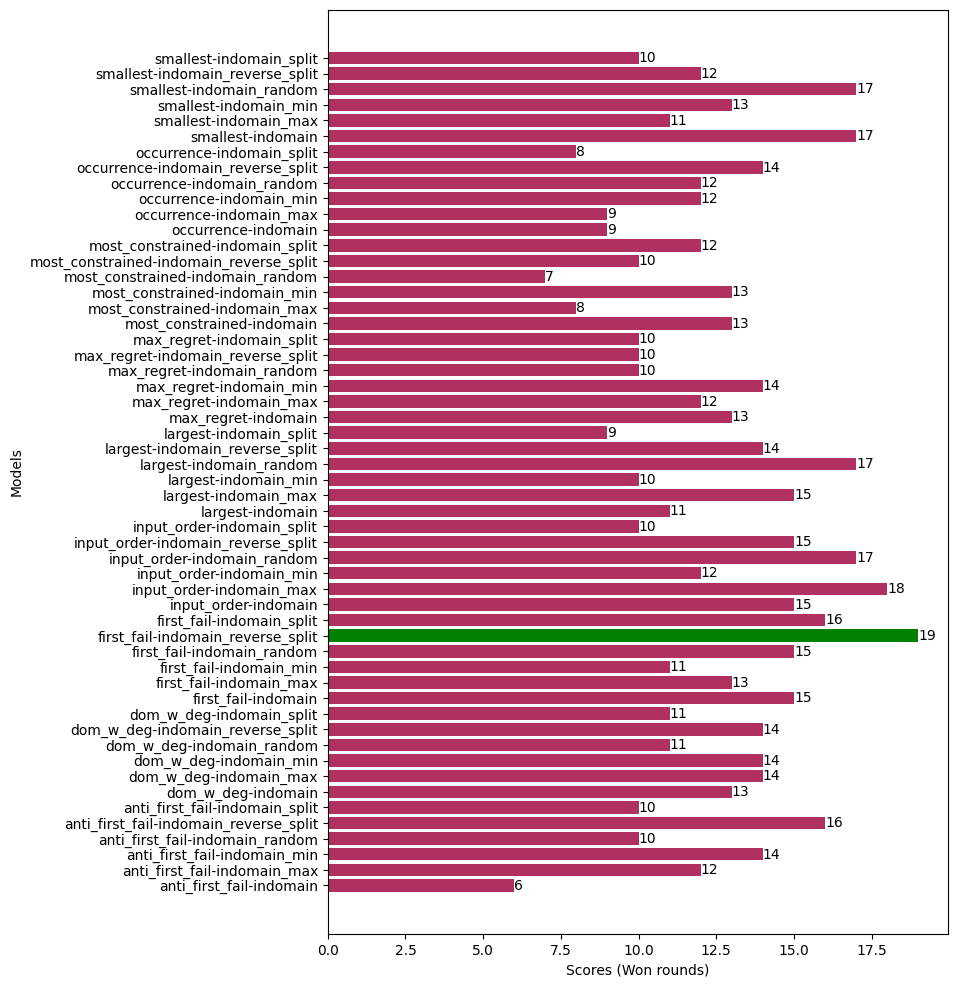

In [5]:
import matplotlib.pyplot as plt 

# Define figure size
fig, ax = plt.subplots(figsize=(8, 12))

models_folder = '../models'  
models = [os.path.join(models_folder, f) for f in os.listdir(models_folder) if f.endswith('.mzn')]
# Filter models and times
models = [model.replace("../models\\", "").replace(".mzn", "") for model in models]

# Set different color for bars with highest values
max_idx = np.max(scores)
colors = ['#b03060' if score != max_idx else 'green' for score in scores]
# Use barh function to create horizontal bar chart
ax.barh(models, scores, color=colors)

# Set x-axis label and y-axis label
ax.set_xlabel('Scores (Won rounds)')
ax.set_ylabel('Models')

# Add value labels next to each bar
for i, v in enumerate(scores):
    ax.text(v, i, str(v), color='black', ha='left', va='center')

# Show the plot
plt.show()
